# Streetcar Delay Prediction - Deep Learning - EXERCISE VERSION

GOAL: predict streetcar delays using a simple Keras model

Refactored to look at delays by hour by day by route by direction

Source dataset: : https://open.toronto.ca/dataset/ttc-streetcar-delay-data/

This version of the notebook includes exercises to be filled in. The exercise cells are identified with "EXERCISE NUMBER..."

# Links to exercises in this notebook <a name='exerciseanchor' />

<a href=#exercise1>Adjust experiments</a>

<a href=#exercise2>Run experiments</a>

<a href=#exercise3>Plot results</a>



# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

# Common imports and global variable definitions

In [1]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import seaborn as sns
# import datetime, timedelta
import datetime
import pydotplus
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math
import sys
from subprocess import check_output
from IPython.display import display
#model libraries
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
#from tf.keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.python.keras.callbacks import TensorBoard
#import datetime
#from datetime import date
from sklearn import metrics
# import pipeline libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from custom_classes import encode_categorical
from custom_classes import prep_for_keras_input
from custom_classes import fill_empty
from custom_classes import encode_text


In [2]:
import tensorflow as tf
tf.__version__ 

'2.9.1'

In [3]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'streetcar_model_training_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')


current directory is: c:\Users\snapb\Documents\GitHub\deep_learning_for_structured_data\notebooks
path_to_yaml c:\Users\snapb\Documents\GitHub\deep_learning_for_structured_data\notebooks\streetcar_model_training_config.yml


In [4]:
# load parameters

repeatable_run = config['test_parms']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(4)
    tf.random.set_seed(7)


testproportion = config['test_parms']['testproportion'] # proportion of data reserved for test set
trainproportion = config['test_parms']['trainproportion'] # proportion of non-test data dedicated to training (vs. validation)
get_test_train_acc = config['test_parms']['get_test_train_acc']
verboseout = config['general']['verboseout']
includetext = config['general']['includetext'] # switch to determine whether text columns are included in the model
save_model_plot = config['general']['save_model_plot'] # switch to determine whether to generate plot with plot_model
tensorboard_callback = config['general']['tensorboard_callback'] # switch to determine if tensorboard callback defined

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetthresh = config['general']['targetthresh']
targetcontinuous = config['general']['targetcontinuous']

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']


# modifier for saved model elements
modifier = config['general']['modifier']

# control whether training controlled by early stop
early_stop = True

# default hyperparameter values
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# date values
date_today = datetime.now()
print("date today",date_today)
start_date =  date(config['general']['start_year'],config['general']['start_month'], config['general']['start_day'])
print("start date",start_date)
end_date = date(config['general']['end_year'],config['general']['end_month'], config['general']['end_day'])
print("end date",end_date)


# pickled original dataset and post-preprocessing dataset
pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = config['general']['pickled_dataframe']
routedirection_file = config['general']['route_direction_file']

# experiment parameter

current_experiment = config['test_parms']['current_experiment']

date today 2022-07-13 16:44:47.317088
start date 2014-01-01
end date 2019-12-31


# Helper functions

In [5]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}


def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)




In [6]:
# get the paths required

def get_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

#  EXERCISE NUMBER 1

In this exercise update the definitions of the following experiments:
1. experiment 1: change the number of epochs (complete iterations through the training dataset) to 5
2. experiment 2: set one_weight (the parameter that accounts for the imbalance between delay and no delay records in the dataset) to the same value it has for experiments 3 to 5, and change the number of epochs to 15

Then update the config file (streetcar_model_training_config.yml) that controls the parameters for training:
- change modifier to 'june17_2020'
- change current_experiment to 1


<a name='exercise1' />
<a href=#exerciseanchor>Back to list of exercises</a>

In [7]:
def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' set the appropriate parameters for the experiment '''
    print("setting parameters for experiment ", experiment_number)
    # default settings for early stopping:
    es_monitor = "val_loss"
    es_mode = "min"
    if experiment_number == 0:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 1
    elif experiment_number == 9:
        #
        early_stop = True
        es_monitor="val_accuracy"
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        get_test_train_acc = False
        #
        epochs = 20    
    elif experiment_number == 1:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 10
    elif experiment_number == 2:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 50
    elif experiment_number == 3:
        #
        early_stop = False
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 4:
        #
        early_stop = True
        es_monitor = "val_loss"
        es_mode = "min"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy"
        '''
        if sys.version_info >= (3,7):
            es_monitor="val_accuracy"
        else:
            es_monitor = "val_acc"
        '''
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)






# Ingest data and create refactored dataframe
- Ingest data for route information and delay information
- Create refactored dataframe with one row per route / direction / timeslot combination

<a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [8]:
# load list of valid routes and directions into dataframe
def ingest_data(path):
    routedirection_frame = pd.read_csv(os.path.join(path,routedirection_file))
    routedirection_frame.tail()
    file_name = os.path.join(path,pickled_dataframe)
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(routedirection_frame, merged_data)

In [9]:
# add derived columns to merged_data dataframe
def prep_merged_data(merged_data):
    # define cols for year month day hour
    merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
    merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
    merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
    merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
    # define time of day column
    merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
    # add a special timeframe for weekends
    merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
    if targetcontinuous:
        merged_data['target'] = merged_data['Min Delay']
    else:
        merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
    return(merged_data)

In [10]:
# generate dataframe containing rows for each timeslot for each route for each direction
# and merge with the input merged_data dataframe to get a result of a sparse dataframe with the
# timeslot / route / direction combinations where delays occurred
def prep_sparse_df(routedirection_frame, merged_data):
    routedirection_frame['count'] = 0
    print("routedirection")
    display(routedirection_frame[:5])
    # define a dataframe with a row for each date to be covered
    days = pd.date_range(start_date, end_date, freq='D')
    date_frame = pd.DataFrame({'date':days,'count':0})
    print("date_frame")
    display(date_frame[:5])
    # define a dataframe with a row for each hour
    hour_list = list(range(0,24))
    hour_frame = pd.DataFrame({'hour':hour_list,'count':0})
    print("hour_frame")
    display(hour_frame[:5])
    #vprint(hour_frame.head())
    # merge date_frame and routedirection
    result1 = pd.merge(date_frame, routedirection_frame, on='count', how='outer')
    print("result1")
    display(result1[:5])
    # merge result1 with hour_frame
    result2 = pd.merge(result1, hour_frame, on='count', how='outer')
    result2 = result2.rename(columns={'date': 'Report Date'})
    result2.Route = result2.Route.astype(str)
    # segment the date
    result2['year'] = pd.DatetimeIndex(result2['Report Date']).year
    result2['month'] = pd.DatetimeIndex(result2['Report Date']).month
    result2['daym'] = pd.DatetimeIndex(result2['Report Date']).day
    result2['day'] = pd.DatetimeIndex(result2['Report Date']).weekday
    print("result2")
    display(result2[:5])
    print("merged_data before")
    display(merged_data[:5])
    # drop extraneous columns from merged_data
    merged_data = merged_data.drop(['Time',
     'Report Date Time',
     'year',
     'month',
     'daym',
     'time_of_day','Min Gap','Location','Incident','Vehicle','target','Day'],axis=1)
    print("merged_data after dropping extraneous columns")
    display(merged_data[:5])
    # join result2 and the trimmed merged_data
    result3 = pd.merge(result2,merged_data ,how='left', on=['Report Date','Route','Direction','hour'])
    result3['Min Delay'].fillna(value=0.0,inplace=True)
    result3['target'] = np.where(result3['Min Delay'] > 0.0, 1, 0 )
    print("result3")
    display(result3[:5])
    return(result3)



In [11]:
# REFACTORED DATAFRAME SHOULD HAVE THE FOLLOWING COLUMNS:
# DAY - for every day in the history from Jan 1 2014 to July 31 2018
# HOUR - for every hour of the day
#  for 501, regular route 5:00 am - midnight; 301 overnight
#   for 503: 7- 10:00 am; 4-7:00 pm
# for 504 5:00 am - 2:00 am; 304 overnight
# for 505 5:00 am - 1:00 am
# for 506 5:00 am - 1:00 am; 306 overnight
# for 509 5:00 am - 1:00 am
# for 510 5:00 am - 2:00 am; 310 overnight
# for 511 5:00 am - 1:00 am
# for 512 5:00 am - 2:00 am
# for 514 (Cherry street)
# ROUTE
# DIRECTION
# DELAY - where this could be count OR duration OR binary

# example of filling in values:
# data['PriceDate'] =  pd.to_datetime(data['PriceDate'], format='%m/%d/%Y')
# data = data.sort_values(by=['PriceDate'], ascending=[True])
# data.set_index('PriceDate', inplace=True)
# print (data)

# data = data.resample('D').ffill().reset_index()
# print (data)

# Master Prep Calls
Contains calls to functions to load data, prep input dataframes, and create refactored dataframe

In [12]:
# master calls
# get the path for data files
path = get_path()
print("path is",path)
# load route direction and delay data datframes
directions_df, merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data)
print("shape of pre refactored dataset", merged_data.shape)
merged_data['year'].value_counts()
merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
merged_data = prep_sparse_df(directions_df, merged_data)
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count of no delay ",count_no_delay)
print("count of delay ",count_delay)
# define parameters for the current experiment
experiment_number = current_experiment
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",early_stop)
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)

path is c:\Users\snapb\Documents\GitHub\deep_learning_for_structured_data\data
shape of pre refactored dataset (58818, 17)
routedirection


,Route,Direction,count
0,301,e,0
1,301,w,0
2,301,b,0
3,304,e,0
4,304,e,0


date_frame


,date,count
0,2014-01-01,0
1,2014-01-02,0
2,2014-01-03,0
3,2014-01-04,0
4,2014-01-05,0


hour_frame


,hour,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


result1


,date,count,Route,Direction
0,2014-01-01,0,301,e
1,2014-01-01,0,301,w
2,2014-01-01,0,301,b
3,2014-01-01,0,304,e
4,2014-01-01,0,304,e


result2


,Report Date,count,Route,Direction,hour,year,month,daym,day
0,2014-01-01,0,301,e,0,2014,1,1,2
1,2014-01-01,0,301,e,1,2014,1,1,2
2,2014-01-01,0,301,e,2,2014,1,1,2
3,2014-01-01,0,301,e,3,2014,1,1,2
4,2014-01-01,0,301,e,4,2014,1,1,2


merged_data before


,Day,Direction,Incident,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle,Report Date Time,year,month,daym,hour,time_of_day,target
Report Date Time,,,,,,,,,,,,,,,,,
2014-01-02 06:31:31,Thursday,e,Late Leaving Garage,dundas and roncesvalles,4.0,8.0,2014-01-02,505,06:31:00,4018,2014-01-02 06:31:31,2014,1,2,6,morning_rush,0
2014-01-02 12:43:43,Thursday,e,Utilized Off Route,king and shaw,20.0,22.0,2014-01-02,504,12:43:00,4128,2014-01-02 12:43:43,2014,1,2,12,midday,1
2014-01-02 14:01:01,Thursday,w,Held By,bingham and kingston road,13.0,19.0,2014-01-02,501,14:01:00,4016,2014-01-02 14:01:01,2014,1,2,14,midday,1
2014-01-02 14:22:22,Thursday,w,Investigation,king st. and roncesvalles,7.0,11.0,2014-01-02,504,14:22:00,4175,2014-01-02 14:22:22,2014,1,2,14,midday,1
2014-01-02 16:42:42,Thursday,e,Utilized Off Route,bathurst and king,3.0,6.0,2014-01-02,504,16:42:00,4080,2014-01-02 16:42:42,2014,1,2,16,aft_rush,0


merged_data after dropping extraneous columns


,Direction,Min Delay,Report Date,Route,hour
Report Date Time,,,,,
2014-01-02 06:31:31,e,4.0,2014-01-02,505,6
2014-01-02 12:43:43,e,20.0,2014-01-02,504,12
2014-01-02 14:01:01,w,13.0,2014-01-02,501,14
2014-01-02 14:22:22,w,7.0,2014-01-02,504,14
2014-01-02 16:42:42,e,3.0,2014-01-02,504,16


result3


,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
0,2014-01-01,0,301,e,0,2014,1,1,2,0.0,0
1,2014-01-01,0,301,e,1,2014,1,1,2,0.0,0
2,2014-01-01,0,301,e,2,2014,1,1,2,0.0,0
3,2014-01-01,0,301,e,3,2014,1,1,2,0.0,0
4,2014-01-01,0,301,e,4,2014,1,1,2,0.0,0


shape of refactored dataset (2952442, 11)
count of no delay  2895077
count of delay  57365
setting parameters for experiment  5
early_stop is  True
one_weight is  50.46765449315785
epochs is  50
es_monitor is  val_accuracy
es_mode is  max


In [13]:
merged_data.shape

(2952442, 11)

# Define test / training sets; encode categorical values; process text field


In [14]:
# get training and test data set
def get_train_validation_test(dataset):
    train, test = train_test_split(dataset, test_size = testproportion)
    dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(dtrain,dvalid,test)



# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [15]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Report Date', 'count', 'Route', 'Direction', 'hour', 'year', 'month', 'daym', 'day', 'Min Delay', 'target']


In [16]:
# define the required column lists
def def_col_lists():
    textcols = [] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
    continuouscols = [] # columns to deal with as continuous values - no embeddings
    if targetcontinuous:
        excludefromcolist = ['count','Report Date', 'target','count_md','Min Delay'] # columns to exclude completely from the model

    else:
        # if target column is not renamed Min Delay put Min Delay in exclusion list
        excludefromcolist = ['count','Report Date', 'target','count_md', 'Min Delay'] # columns to exclude completely from the model
    nontextcols = list(set(allcols) - set(textcols))
    collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))
    for col in continuouscols:
        print("col is",col)
        merged_data[col] = merged_data[col].astype(float)
        print("got through one")
        superset_data[col] = superset_data[col].astype(float)
    # print column list lengths and contents:
    print("allcols",len(allcols))
    print("excludefromcolist",len(excludefromcolist))
    print(excludefromcolist)
    print("textcols",len(textcols))
    print(textcols)
    print("continuouscols",len(continuouscols))
    print(continuouscols)
    print("collist",len(collist))
    print(collist)
    return(collist,continuouscols,textcols)

# Invoke Pipeline

In [17]:
# define keras variables


# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))

    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input






In [18]:
# master block to invoke pipeline

# build fully qualified names for the files for saving the pipelines
pipeline_path = get_pipeline_path()
pipeline1_file_name = os.path.join(pipeline_path,'sc_delay_pipleline'+modifier+'.pkl')
pipeline2_file_name = os.path.join(pipeline_path,'sc_delay_pipleline_keras_prep'+modifier+'.pkl')

# define column lists:
collist,continuouscols,textcols = def_col_lists()

# create objects of the pipeline classes
fe = fill_empty()
ec = encode_categorical()
pk = prep_for_keras_input()

# need to implement the pipeline in two parts:
# 1. fill empty + encode categoricals
# 2. prep for Keras
# because part 1 needs to be applied to the entire dataset and part 2 to the individual train, validate, and test sets


sc_delay_pipeline = Pipeline([('fill_empty',fe),('encode_categorical',ec)])
sc_delay_pipeline_keras_prep = Pipeline([('prep_for_keras',pk)])



# provide the value for each parameter of each of the pipeline classes

sc_delay_pipeline.set_params(fill_empty__collist = collist, fill_empty__continuouscols = continuouscols,
                            fill_empty__textcols = textcols,encode_categorical__col_list = collist)
sc_delay_pipeline_keras_prep.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)

# fit the input dataset to the pipeline

# first fit the first segment of pipeline on the whole dataset
X = sc_delay_pipeline.fit_transform(merged_data)
max_dict = ec.max_dict
# then split dataset
dump(sc_delay_pipeline, open(pipeline1_file_name,'wb'))
dump(sc_delay_pipeline_keras_prep, open(pipeline2_file_name,'wb'))
dtrain, dvalid, test = get_train_validation_test(X)
# then apply second portion of pipeline to each subset

X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)

print("keras variables defined")
print("X_train_list",X_train_list)



allcols 11
excludefromcolist 5
['count', 'Report Date', 'target', 'count_md', 'Min Delay']
textcols 0
[]
continuouscols 0
[]
collist 7
['day', 'month', 'Direction', 'daym', 'Route', 'hour', 'year']
fill empty xform
col is  day
col is  month
col is  Direction
col is  daym
col is  Route
col is  hour
col is  year
transform col is  day
after transform col is  day
transform col is  month
after transform col is  month
transform col is  Direction
after transform col is  Direction
transform col is  daym
after transform col is  daym
transform col is  Route
after transform col is  Route
transform col is  hour
after transform col is  hour
transform col is  year
after transform col is  year
Through train test split. Test proportion:
0.2
cat col is day
cat col is month
cat col is Direction
cat col is daym
cat col is Route
cat col is hour
cat col is year
cat col is day
cat col is month
cat col is Direction
cat col is daym
cat col is Route
cat col is hour
cat col is year
cat col is day
cat col is mon

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [19]:
# define model in Keras

def get_model():


    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings


    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])



    # define layers for text columns
    if includetext:
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col]))
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")

    # define layers for continuous columns
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])



    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])

    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])

    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])

    print("main_l", main_l)



    # define output layer
    output = Dense(1, activation=output_activation) (main_l)

    # define model

    model = Model(inputlayerlist, output)


    # define optimizer
    optimizer = SGD(lr=learning_rate)

    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    # model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy", Recall(), Precision()], weighted_metrics=["accuracy"])
    


    return model


model = get_model()

# output model summary

model.summary()




about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l KerasTensor(type_spec=TensorSpec(shape=(None, 70), dtype=tf.float32, name=None), name='concatenate_5/concat:0', description="created by layer 'concatenate_5'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 day (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        70          ['day[0][0]']                    
              

c:\Users\snapb\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [20]:
# save model plot
if save_model_plot:
    model_plot_file = "model_plot"+modifier+".png"
    model_plot_path = os.path.join(get_path(),model_plot_file)
    print("model plot path: ",model_plot_path)
    plot_model(model, to_file=model_plot_path)

In [21]:
# set up early stopping
def set_early_stop(es_monitor, es_mode):
    ''' given monitoring parameter es_monitor and mode es_mode, define early stopping callback, save model callback, and 
    TensorBoard callback'''
    # define callback for early stopping
    callback_list = []
    es = EarlyStopping(monitor=es_monitor, mode=es_mode, verbose=1,patience = patience_threshold)
    callback_list.append(es)
    model_path = get_model_path()
    save_model_path = os.path.join(model_path,'scmodel'+modifier+"_"+str(experiment_number)+'.h5')
    # define callback to save best model
    mc = ModelCheckpoint(save_model_path, monitor=es_monitor, mode=es_mode, verbose=1, save_best_only=True)
    callback_list.append(mc)
    # define callback for TensorBoard
    if tensorboard_callback:
        tensorboard_log_dir = os.path.join(get_path(),"tensorboard_log",datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard = TensorBoard(log_dir= tensorboard_log_dir)
        callback_list.append(tensorboard)
    return(callback_list,save_model_path)

#  EXERCISE NUMBER 2 - RUN EXPERIMENTS

In this exercise you will run a series of experiments and watch the behaviour of the training run:
1. exercise 2.1: this is a minimal exercise that simply validates that the code is working correctly. You will not get a useful trained model out of this experiment. To run this experiment: 
    - update the config file (streetcar_model_training_config.yml) to set experiment = 0 and save your changes to the config file
    - run all the cells in the notebook up to this point (Cell -> Run All Above)
    - run the following cell and note the final output (val_accuracy, CPU time and wall time)
2. exercise 2.2: in this exercise you will run one of the experiments you updated in exercise 1:
    - update the config file to set experiment = 1 and modifier = "june17_exercise2_2" and save your changes
    - run all the cells in the notebook up to this point (Cell -> Run All Above)
    - run the following cell and note the final output (val_accuracy, CPU time and wall time)
3. exercise 2.3: in this exercise you will run the other experiment you updated in exercise 1:
    - update the config file to set experiment = 2 and modifier = "june17_exercise2_3" and save your changes
    - run all the cells in the notebook up to this point (Cell -> Run All Above)
    - run the following cell and note the final output (val_accuracy, CPU time and wall time)
4. exercise 2.4: in this exercise you will run an experiment that includes early stopping:
    - update the config file to set experiment = 9, modifier = "june17_exercise2_4" and patience_threshold = 2
    - run all the cells in the notebook up to this point (Cell -> Run All Above)
    - run the following cell and note the final output (val_accuracy, CPU time and wall time)
    - how many epochs did you get for this run?
4. exercise 2.5: in this exercise you will run an experiment that includes early stopping and a higher patience threshold:
    - update the config file to set experiment = 9, modifier = "june17_exercise2_4" and patience_threshold = 7
    - run all the cells in the notebook up to this point (Cell -> Run All Above)
    - run the following cell and note the final output (val_accuracy, CPU time and wall time)
    - how many epochs was this run? Why was it different than exercise 2.4?
5. exercise 2.6: in this exercise you will run a full-blown experiment with early stopping and large number of epochs:
    - update the config file to set experiment = 9, modifier = "june17_exercise2_5" and patience_threshold = 15
    - run all the cells in the notebook up to this point (Cell -> Run All Above)
    - run the following cell and note the final output (val_accuracy, CPU time and wall time)
    - how many epochs was this run? How does the validation accuracy compare to other exercises?

When you have completed these exercises:
- update the config file to set get_test_train_acc to False (this will skip the long-running step that gets overall accuracy for the test and train datasets - later you can set get_test_train_acc back to True and rerun the getting test and train accuracy) 
- run the remaining cells in the notebook following the next one (Cell -> Run All Below)


<a name='exercise2' />
<a href=#exerciseanchor>Back to list of exercises</a>

In [22]:
# %%time
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",batch_size)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)
print("patience_threshold is ",patience_threshold)
print("experiment number is ",experiment_number)
print("early stop is",early_stop)
# get definitions
callback_list, save_model_path = set_early_stop(es_monitor, es_mode)
model = get_model()
if early_stop:
       modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
        , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1,callbacks=callback_list)
else:
    modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols []
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 50
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
patience_threshold is  15
experiment number is  5
early stop is True
about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l KerasTensor(type_spec=TensorSpec(shape=(None, 70), dtype=tf.float32, name=None), name='concatenate_11/concat:0', description="created by layer 'concatenate_11'")
Epoch 1/50
1882/1890 [============================>.] - ETA: 0s - loss: 0.9687 - accuracy: 0.6153 - weighted_accuracy: 0.7488
Epoch 1: val_accuracy improved from -inf to 0.69158, saving model to c:\Users\snapb\Documents\GitHub\deep_learning_for_structured_data\models\scmodelmay16_2020_5.h5
1890/1890 [==============================] - 10s 4ms/step - loss: 0.9686 - accuracy: 0.6156 - weighted_accuracy: 0.7489 - val_loss: 0.5462 - val_accuracy: 0.6916 - val_weighted_accuracy: 0.691

In [23]:
# save model elements explicitly if not saved as part of early_stop
if early_stop == False:
    model_json = model.to_json()
    model_path = get_model_path()
    with open(os.path.join(model_path,'model'+modifier+'.json'), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(model_path,'scweights'+modifier+'.h5'))
    save_model_path = os.path.join(model_path,'scmodel'+modifier+'.h5')
    model.save(save_model_path,save_format='h5')
    # no early stop, so make current model saved_model
    saved_model = model
    print("Saved model, weights to disk")


In [24]:
saved_model = load_model(save_model_path)
print("metrics names ",saved_model.metrics_names)
# getting test and train accuracy is time consuming - check to see if experiment requires it
if get_test_train_acc:
    if len(saved_model.metrics_names) == 2:
        # saved_model.evaluate returns ['loss', 'acc']
        _, train_acc = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
        _, test_acc = saved_model.evaluate(X_test, test.target, verbose=0)
    else:
        # saved_model.evaluate returns ['loss', 'accuracy', 'accuracy_1']
        _, train_acc,_ = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
        _, test_acc,_ = saved_model.evaluate(X_test, test.target, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))




metrics names  ['loss', 'accuracy', 'weighted_accuracy']
Train: 0.750, Test: 0.750


In [25]:
X_train_list

[array([1, 1, 6, ..., 1, 5, 4], dtype=int64),
 array([ 1,  8,  2, ...,  8,  9, 11], dtype=int64),
 array([4, 0, 4, ..., 0, 3, 2]),
 array([12, 25, 23, ...,  4,  3, 26], dtype=int64),
 array([10,  0,  2, ...,  5,  8, 12]),
 array([ 3, 16,  2, ..., 10, 14,  7], dtype=int64),
 array([4, 3, 5, ..., 3, 0, 5], dtype=int64)]

In [26]:
X_train_list[0]

array([1, 1, 6, ..., 1, 5, 4], dtype=int64)

# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [27]:
saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 day (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 10)        70          ['day[0][0]']                    
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 10)        120         ['month[0][0]']                  
                                                                                            

In [28]:
if presaved == True:
    batch_size = 1000
    epochs = 1
    modelfit2 = loaded_model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

# Predictions and renderings

In [29]:
# functions to parse and manipulate dates in the style of the input CSVs

def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [30]:
type(X_test)

dict

In [31]:
list(X_test_list[0])

[6,
 0,
 3,
 0,
 5,
 4,
 5,
 3,
 6,
 4,
 4,
 1,
 0,
 3,
 5,
 1,
 1,
 5,
 1,
 4,
 3,
 6,
 2,
 5,
 3,
 3,
 3,
 2,
 2,
 0,
 3,
 2,
 0,
 5,
 3,
 0,
 2,
 5,
 3,
 3,
 5,
 3,
 2,
 3,
 1,
 6,
 1,
 3,
 2,
 5,
 5,
 5,
 1,
 5,
 1,
 1,
 3,
 1,
 3,
 2,
 2,
 0,
 0,
 0,
 5,
 2,
 2,
 6,
 5,
 1,
 6,
 3,
 6,
 0,
 1,
 0,
 4,
 3,
 5,
 2,
 4,
 3,
 4,
 1,
 5,
 2,
 5,
 6,
 5,
 0,
 3,
 0,
 2,
 0,
 1,
 1,
 5,
 0,
 3,
 3,
 2,
 5,
 3,
 0,
 2,
 0,
 5,
 1,
 0,
 4,
 4,
 5,
 5,
 6,
 5,
 6,
 3,
 3,
 5,
 4,
 3,
 3,
 1,
 1,
 4,
 2,
 3,
 3,
 5,
 0,
 4,
 6,
 2,
 4,
 0,
 4,
 0,
 0,
 6,
 5,
 1,
 6,
 6,
 6,
 2,
 5,
 3,
 4,
 4,
 6,
 0,
 5,
 1,
 1,
 3,
 3,
 3,
 3,
 6,
 0,
 6,
 6,
 1,
 5,
 4,
 2,
 0,
 1,
 3,
 3,
 1,
 2,
 3,
 6,
 0,
 2,
 2,
 6,
 5,
 1,
 4,
 6,
 3,
 4,
 4,
 4,
 1,
 6,
 6,
 0,
 3,
 4,
 2,
 2,
 0,
 4,
 0,
 2,
 2,
 6,
 3,
 4,
 4,
 0,
 0,
 2,
 2,
 0,
 3,
 4,
 0,
 0,
 6,
 4,
 4,
 3,
 1,
 2,
 5,
 0,
 2,
 6,
 1,
 4,
 5,
 2,
 4,
 1,
 1,
 1,
 6,
 1,
 5,
 5,
 2,
 2,
 0,
 5,
 3,
 1,
 5,
 2,
 5,
 5,
 2,
 0,
 2,
 3,
 2,
 2,


In [32]:
print("X_test ", X_test)

X_test  {'day': array([6, 0, 3, ..., 4, 5, 4], dtype=int64), 'month': array([ 6,  6, 11, ...,  3, 10, 11], dtype=int64), 'Direction': array([3, 2, 0, ..., 3, 1, 0]), 'daym': array([ 9,  0, 30, ...,  4, 25,  6], dtype=int64), 'Route': array([10, 10, 11, ...,  7,  4,  3]), 'hour': array([10, 14, 15, ...,  4, 19,  2], dtype=int64), 'year': array([2, 5, 1, ..., 5, 2, 4], dtype=int64)}


In [33]:
# predictions on training set

preds = saved_model.predict(X_test, batch_size=batch_size)

591/591 [==============================] - 1s 2ms/step


In [34]:
preds.shape

(590489, 1)

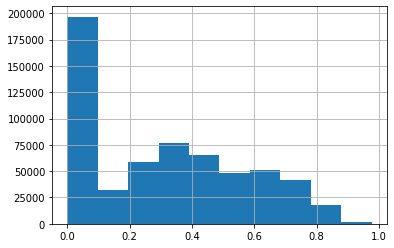

In [35]:
test["predict"] = preds
test.predict[:5]
if verboseout:
    test.predict.hist()

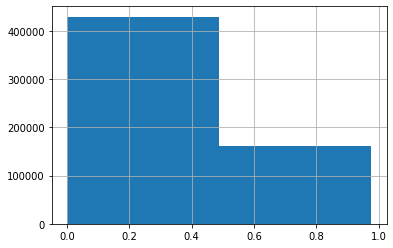

In [36]:
if verboseout:
    test.predict.hist(bins=2)

In [37]:
# get rounded predictions
test["predround"] = preds.round().astype(int)
test.predround[:5]

1242433    0
2706120    0
983448     0
601275     0
1070457    1
Name: predround, dtype: int32

In [38]:
print("test target 0",test[test['target']==0].shape[0])
print("test target 1",test[test['target']==1].shape[0])
print("test predround 0",test[test['predround']==0].shape[0])
print("test predround 1",test[test['predround']==1].shape[0])

test target 0 578978
test target 1 11511
test predround 0 435586
test predround 1 154903


In [39]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(test.target[:100000] - test.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct test")
print((len(deltatr) - deltatr.sum())/len(deltatr))



25030
percentage correct test
0.7497


In [40]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=batch_size)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





473/473 [==============================] - 1s 2ms/step


2513606    0.000000
1990928    0.070294
1742445    0.342669
2706179    0.431167
262844     0.242779
Name: predict, dtype: float32

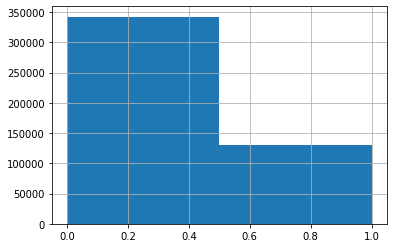

In [41]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [42]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


2513606    0
1990928    0
1742445    0
2706179    0
262844     0
2348409    0
1207583    0
2196018    0
8815       0
655136     0
Name: deltaval, dtype: int32
124263


In [43]:
# hand calculation of proportion correct guesses in validation set

test["deltaval"] = abs(test.target - test.predround)
print(test["deltaval"][:10])
print(test["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))

1242433    0
2706120    0
983448     0
601275     0
1070457    1
2645478    0
1024073    0
2493002    0
1449710    0
654908     0
Name: deltaval, dtype: int32
147910


In [44]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predround,predict,deltaval
691186,2015-05-28,0,12,1,1,1,4,27,3,0.0,0,1,0.607664,1
1223916,2016-06-26,0,13,4,23,2,5,25,6,0.0,0,1,0.656567,1
2776072,2019-08-22,0,11,1,6,5,7,21,3,0.0,0,1,0.602832,1
1354031,2016-10-01,0,9,4,10,2,9,0,5,0.0,0,1,0.691865,1
2623444,2019-05-01,0,4,4,20,5,4,0,2,0.0,0,1,0.695350,1
367346,2014-09-30,0,9,4,3,0,8,29,1,0.0,0,1,0.646189,1
2317617,2018-09-16,0,7,4,0,4,8,15,6,0.0,0,1,0.760824,1
613888,2015-04-01,0,7,2,12,1,3,0,2,0.0,0,1,0.591190,1
1301049,2016-08-23,0,4,4,2,2,7,22,1,0.0,0,1,0.737868,1
610317,2015-03-29,0,11,4,19,1,2,28,6,0.0,0,1,0.710137,1


In [45]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
testwrong = test.loc[(test.deltaval == 1)]
testright = test.loc[(test.deltaval == 0)]
testwrong.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predict,predround,deltaval
1070457,2016-03-05,0,4,4,12,2,2,4,5,0.0,0,0.737062,1,1
626010,2015-04-10,0,7,2,7,1,3,9,4,0.0,0,0.618042,1,1
94103,2014-03-11,0,13,1,7,0,2,10,1,0.0,0,0.752614,1,1
852047,2015-09-25,0,4,4,5,1,8,24,4,0.0,0,0.811256,1,1
1426858,2016-11-24,0,9,4,13,2,10,23,3,0.0,0,0.753656,1,1
2638672,2019-05-12,0,9,1,22,5,4,11,6,0.0,0,0.540758,1,1
436409,2014-11-20,0,12,1,18,0,10,19,3,0.0,0,0.617009,1,1
1294665,2016-08-18,0,8,4,11,2,7,17,3,0.0,0,0.628351,1,1
1548042,2017-02-22,0,7,4,14,3,1,21,2,0.0,0,0.727628,1,1
1681944,2017-06-01,0,12,4,5,3,5,0,3,0.0,0,0.605790,1,1


<AxesSubplot:>

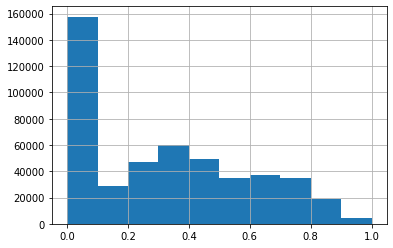

In [46]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

<AxesSubplot:>

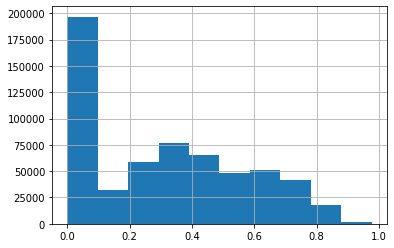

In [47]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
test.predict.hist()

In [48]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


26160
percentage correct validate
0.7384


#  EXERCISE NUMBER 3

In this exercise update these charts so that they also include:
1. training accuracy - 'accuracy'
2. training loss - 'loss'

To do this you will need to:
- add a new plt.plot statement that is indexed to these measurements
- add a plt.legend statement with meaningingful values substituted for 'label1' and 'label2'

plt.legend(['label1', 'label2'], loc='upper left')




<a name='exercise3' />
<a href=#exerciseanchor>Back to list of exercises</a>

dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


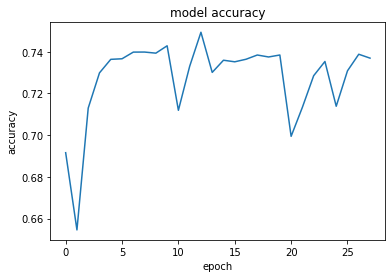

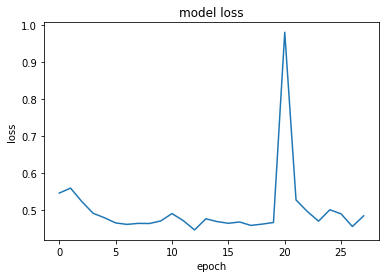

In [49]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# Loss
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

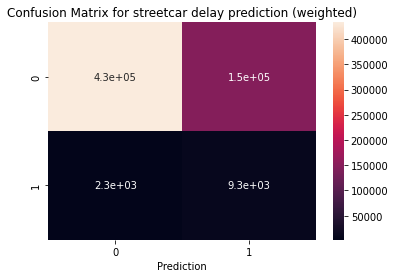

In [50]:


cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=test["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction (weighted)")
plt.show()

In [51]:
model.metrics_names

['loss', 'accuracy', 'weighted_accuracy']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at Intact Insurance.